"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [334]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence

[44 78]
[  0  44  78 100]
[0.46180539 0.96429952 0.81120231]


Text(0, 0.5, 'Firing Rate')

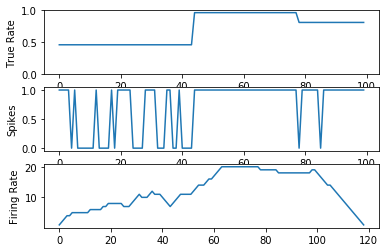

In [313]:
# Some poisson spiking
length = 100
states = 3
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random(states)

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros(length)
for num, val in enumerate(true_lambda):
    true_r[state_inds[num]:state_inds[num+1]] = val
  
data_vec = np.random.random(length) < true_r
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(3,1)
ax[0].plot(true_r)
ax[0].set_ylim(0,1)
ax[1].plot(data_vec)
ax[2].plot(np.convolve(data_vec,np.ones(20)))
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")
ax[2].set_ylabel("Firing Rate")

In [314]:
def create_model(data_vec, states, likelihood_type = 'poisson'):
    with pm.Model() as model:
        if likelihood_type == 'poisson':
            lambda_latent = pm.Exponential('lambda', 
                                            1/np.mean(data_vec), 
                                            shape = states,
                                          testval = np.mean(data_vec))
        elif likelihood_type == 'bernoulli':
            # Finite, but somewhere on the lower end, Beta prior
            a_lambda = 2
            b_lambda = 5
            lambda_latent = pm.Beta('lambda', 
                                            a_lambda, b_lambda, 
                                            shape = states,
                                          testval = np.mean(data_vec))

        a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
        b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
        
        even_switches = np.linspace(0,1,states+1)[1:-1]
        tau_latent = pm.Beta('tau_latent', a, b, 
                             testval = even_switches,
                             shape = (states-1)).sort(axis=-1)
                             

        tau = pm.Deterministic('tau', 
                idx.min() + (idx.max() - idx.min()) * tau_latent)

        # Sigmoing to create transitions based off tau
        # Hardcoded 3-5 states
        weight_1_stack = tt.nnet.sigmoid(idx - tau[0])
        if states > 2:
            weight_2_stack = tt.nnet.sigmoid(idx - tau[1])
        if states > 3:
            weight_3_stack = tt.nnet.sigmoid(idx - tau[2])
        if states > 4:
            weight_4_stack = tt.nnet.sigmoid(idx - tau[3])

        # Generate firing rates from lambda and sigmoid weights
        if states == 2:
            # 3 states
            lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[0]) + \
                    np.multiply(weight_1_stack, lambda_latent[1])

            
        if states == 3:
            # 3 states
            lambda_ = np.multiply(1 - weight_1_stack, lambda_latent[0]) + \
                    np.multiply(weight_1_stack * (1 - weight_2_stack), 
                            lambda_latent[1]) + \
                    np.multiply(weight_2_stack, 
                                lambda_latent[2])

        elif states == 4:
            # 4 states
            lambda_ = np.multiply(1 - weight_1_stack, 
                            lambda_latent[0]) + \
                    np.multiply(weight_1_stack * (1 - weight_2_stack), 
                            lambda_latent[1]) + \
                    np.multiply(weight_2_stack * (1 - weight_3_stack), 
                            lambda_latent[2]) + \
                    np.multiply(weight_3_stack, 
                                lambda_latent[3])

        elif states == 5:
            # 5 states
            lambda_ = np.multiply(1 - weight_1_stack, 
                            lambda_latent[0]) + \
                    np.multiply(weight_1_stack * (1 - weight_2_stack), 
                            lambda_latent[1]) + \
                    np.multiply(weight_2_stack * (1 - weight_3_stack), 
                            lambda_latent[2]) +\
                    np.multiply(weight_3_stack * (1 - weight_4_stack), 
                            lambda_latent[3])+ \
                    np.multiply(weight_4_stack, 
                            lambda_latent[4])

        # Add observations
        if likelihood_type == 'poisson':
            observation = pm.Poisson("obs", lambda_, observed=data_vec)
        elif likelihood_type == 'bernoulli':
            observation = pm.Bernoulli("obs", lambda_, observed=data_vec)
    return model

In [315]:
model_type_list = ['poisson','bernoulli']
model_list = [create_model(data_vec, states,this_type) \
              for this_type in model_type_list]

In [349]:
def fit_model(model,fit,samples):
    with model:
        inference = pm.ADVI('full-rank')
        approx = pm.fit(n=fit, method=inference,
                       random_seed = 3,callbacks=[CheckParametersConvergence()],
                       obj_n_mc = 1)
        trace = approx.sample(draws=samples)
        #trace = pm.sample(samples, tune=2500, 
        #              chains = 4, cores = 4)
    return approx,trace
    #return trace

In [350]:
fit_list = [fit_model(this_model,fit,samples) for this_model in model_list]

Average Loss = 100.9: 100%|██████████| 100000/100000 [00:29<00:00, 3393.72it/s]
Finished [100%]: Average Loss = 100.89
Average Loss = 58.079: 100%|██████████| 100000/100000 [00:29<00:00, 3345.35it/s]
Finished [100%]: Average Loss = 58.082


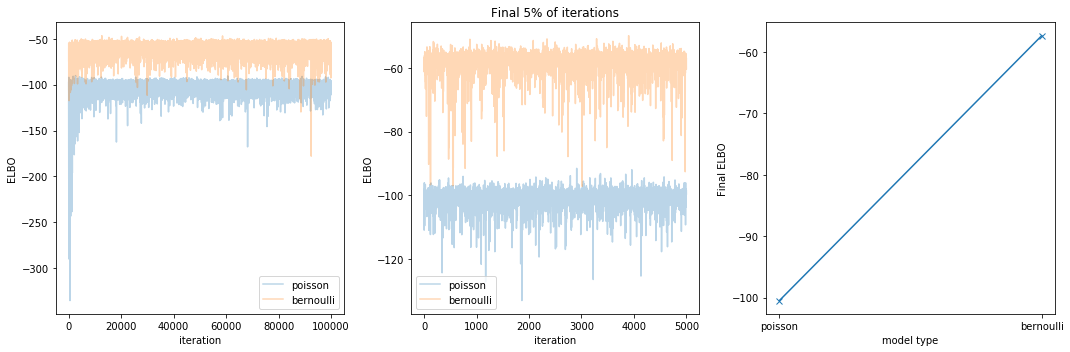

In [351]:
fig,ax = plt.subplots(1,3,figsize=(15,5))
for num, this_fit in enumerate(fit_list):
    ax[0].plot(-this_fit[0].hist, label=model_type_list[num], alpha=.3)
ax[0].legend()
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
for num, this_fit in enumerate(fit_list):
    ax[1].plot(-this_fit[0].hist[ind:], label=model_type_list[num], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].legend()
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

# Plot final value
fin_elbo = [np.median(-x[0].hist[ind:],axis=None) for x in fit_list]
ax[2].plot(model_type_list,fin_elbo,'-x');
max_elbo = np.max(fin_elbo)
#ax[2].scatter(model_type_list[np.where(fin_elbo == max_elbo)[0]],max_elbo,c='red');
ax[2].set_ylabel('Final ELBO')
ax[2].set_xlabel('model type');
plt.tight_layout()
fig.savefig(f'{states}_state_elbo')

In [352]:
ppc_list = [pm.sample_posterior_predictive(this_fit[1], samples = 2000, model = this_model) \
#ppc_list = [pm.sample_posterior_predictive(this_fit, samples = 2000, model = this_model) \
            for this_fit, this_model in zip(fit_list,model_list)]

100%|██████████| 2000/2000 [00:01<00:00, 1337.82it/s]


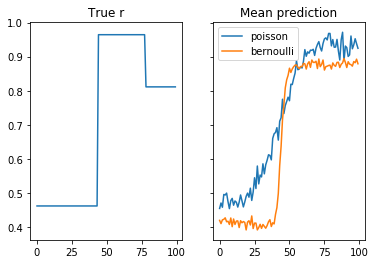

In [353]:
fig,ax = plt.subplots(1,2,sharey=True)
ax[0].plot(true_r)
for num, this_ppc in enumerate(ppc_list):
    ax[1].plot(np.mean(this_ppc['obs'],axis=0), label=model_type_list[num], alpha=1)
ax[0].set_title('True r')
ax[1].set_title('Mean prediction')
plt.legend()
fig.savefig(f'{states}_state_ppc')

In [354]:
#min_val,max_val = min(true_r),max(true_r)
tau_list = [this_fit[1]['tau'] for this_fit in fit_list]
#tau_list = [this_fit['tau'] for this_fit in fit_list]
mode_tau = [stats.mode(np.vectorize(np.int)(x),axis=0)[0].flatten() for x in tau_list]
mode_tau[0]

array([34, 42])

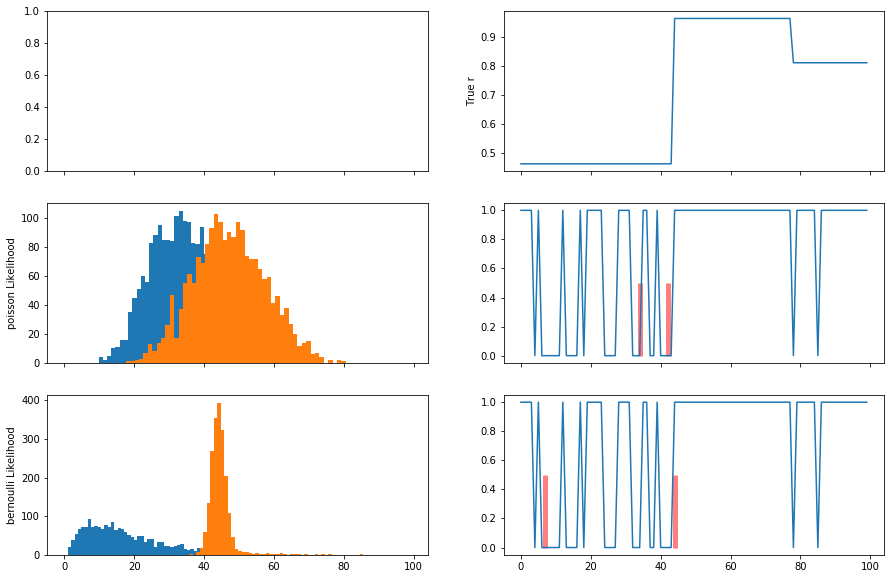

In [355]:
fig,ax = plt.subplots(3,2,sharex=True,figsize=(15,10))
ax[0,1].plot(true_r)
ax[0,1].set_ylabel('True r')
#ax[0,1].plot(data_vec,alpha = 0.5)
#ax[0,1].set_ylabel('Binned spike counts')
for num, this_fit in enumerate(tau_list):
    for tau_num, this_tau in enumerate(this_fit.T):
        ax[1+num,0].hist(this_tau,bins=50)
        ax[1+num,1].vlines(mode_tau[num][tau_num],0,0.5,color='red',alpha=0.5,linewidth=5)
    ax[1+num,1].plot(data_vec)
    ax[1+num,0].set_ylabel(f'{model_type_list[num]} Likelihood')
fig.savefig(f'{states}_state_tau_hists')